# Pendientes

Nada

# Gpu

In [63]:
!nvidia-smi

Wed Sep 17 15:18:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [64]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Set_Up

In [65]:
symbol = "BTCUSD"
root_data = f'/content/drive/MyDrive/Course Folder/Forex/XAUUSD/'
print(root_data)

direction = 'Short'
direction_number = -1

symbol = 'BTCUSD'
strategy = 'Kalman'
time_frame = 'M5'

trade_evolution = 'st_Max'
result_field = 'st_PnL'


/content/drive/MyDrive/Course Folder/Forex/XAUUSD/


# Libraries

In [66]:
!pip install ta-lib
import talib as ta
print(ta.__version__)

0.6.7


In [67]:
import numpy as np
import pandas as pd
import os
import joblib
import math
import time

from itertools import combinations, product

from tqdm.auto import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from xgboost import XGBClassifier, XGBRegressor

import tensorflow as tf

import sys
sys.path.append("..")

from __future__ import annotations
from typing import Tuple, List, Optional, Dict, Any

from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, log_loss, r2_score)

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data



## Features

In [70]:
def kalman_line(source, kalman_length: int, smooth: int):
    """
    Pine -> Python (solo 'kalman_line'), replicando la EMA de TradingView con
    *semilla SMA* (como ta.ema) sobre el núcleo Kalman kf_c.

    Parámetros
    ----------
    source : pd.Series o array-like de floats (precio crudo, sin diff/returns)
    kalman_length : int   (equivale a length_kal en Pine)
    smooth : int          (equivale a smooth_kal en Pine -> ta.ema(kf_c, smooth))

    Retorna
    -------
    Mismo tipo que `source`: pd.Series o np.ndarray con la línea Kalman suavizada.
    """
    import numpy as np
    import pandas as pd

    # normalizamos tipos
    is_series = hasattr(source, "index")
    idx = source.index if is_series else None
    x = np.asarray(source, dtype=np.float64)
    n = x.shape[0]
    if n == 0:
        return source

    # ---------- núcleo Kalman idéntico al Pine ----------
    sqrt_term   = np.sqrt((kalman_length / 10000.0) * 2.0)
    length_term = kalman_length / 10000.0

    kf_c   = np.empty(n, dtype=np.float64)
    velo_c = np.empty(n, dtype=np.float64)

    # bar 0 (nz(kf_c[1], source) y nz(velo_c[1], 0))
    kf_c[0] = x[0]
    velo_c[0] = 0.0

    for i in range(1, n):
        prev_kf = kf_c[i - 1]
        dk_c = x[i] - prev_kf
        smooth_c = prev_kf + dk_c * sqrt_term
        velo_c[i] = velo_c[i - 1] + length_term * dk_c
        kf_c[i] = smooth_c + velo_c[i]

    # ---------- EMA con semilla SMA (comportamiento ta.ema de TV) ----------
    L = int(max(1, smooth))
    alpha = 2.0 / (L + 1.0)
    ema = np.full(n, np.nan, dtype=np.float64)

    if n < L:
        # con pocas barras, igualamos al promedio simple disponible
        ema[-1] = np.nanmean(kf_c)
    else:
        # seed = SMA de las primeras L barras
        seed = np.mean(kf_c[:L])
        ema[L - 1] = seed
        for i in range(L, n):
            ema[i] = alpha * kf_c[i] + (1.0 - alpha) * ema[i - 1]

    return (pd.Series(ema, index=idx) if is_series else ema)


In [71]:
def slope(src: pd.Series,
          length_kal: int,
          smooth_kal: int,
          slopeLen: int,
          offset: int) -> pd.DataFrame:

    n = len(src)
    kf_state = np.full(n, np.nan)
    kf_velo  = np.zeros(n)
    sqrt_factor = np.sqrt(length_kal / 10000.0 * 2.0)
    vel_factor  = length_kal / 10000.0

    for i in range(n):
        if i == 0:
            prev_state = src.iloc[0]
            prev_velo  = 0.0
        else:
            prev_state = kf_state[i-1] if not np.isnan(kf_state[i-1]) else src.iloc[i]
            prev_velo  = kf_velo[i-1]

        dk = src.iloc[i] - prev_state
        smooth = prev_state + dk * sqrt_factor
        kf_velo[i]  = prev_velo + vel_factor * dk
        kf_state[i] = smooth + kf_velo[i]

    # 2) EMA smoothing --------------------------------------------------
    kal = pd.Series(kf_state, index=src.index).ewm(span=smooth_kal, adjust=False).mean()

    # 3) Slope/divergence -----------------------------------------------
    validLen = max(slopeLen, 1)
    slope_div = kal.diff(validLen) / validLen
    slope_signal = (slope_div > slope_div.shift(1)).astype(int)

    # 4) Angle in degrees -----------------------------------------------
    price_change = kal - kal.shift(validLen)
    slope_angle = np.degrees(np.arctan(price_change))
    slope_angle_signal = (slope_angle > slope_angle.shift(1)).astype(int)

    # 5) Linear regression prediction ----------------------------------
    def _linreg(y):
        x = np.arange(len(y))
        m, b = np.polyfit(x, y, 1)
        return b + m * (len(y)-1)

    slope_lin_reg = kal.rolling(window=slopeLen).apply(_linreg, raw=False)
    slope_lin_reg = slope_lin_reg.shift(-offset)  # apply Pine-style offset
    slope_lin_reg_signal = (slope_lin_reg > slope_lin_reg.shift(1)).astype(int)

    # 6) Pack results ---------------------------------------------------
    return pd.DataFrame({
        'slope_div':            slope_div,
        'slope_signal':         slope_signal,
        'slope_angle':          slope_angle,
        'slope_angle_signal':   slope_angle_signal,
        'slope_lin_reg':        slope_lin_reg,
        'slope_lin_reg_signal': slope_lin_reg_signal
    })

In [72]:
help(ta.OBV)

Help on function OBV in module talib._ta_lib:

OBV(real, volume)
    OBV(ndarray real, ndarray volume)

    OBV(real, volume)

    On Balance Volume (Volume Indicators)

    Inputs:
        real: (any ndarray)
        prices: ['volume']
    Outputs:
        real



In [73]:
def create_features(stock_data: pd.DataFrame) -> pd.DataFrame:

    periods        = [3, 7, 14]
    ema_periods    = [10, 21, 50, 100, 200]
    kalman_periods = [300, 600, 900]
    slope_length   = [3, 6, 9]

    features = pd.DataFrame(index=stock_data.index)


    def _unique_pairwise(columns: List[str]) -> List[Tuple[str, str]]:
        """Return ordered unique column pairs without self-pairings."""
        unique_columns = list(dict.fromkeys(columns))
        return list(combinations(unique_columns, 2))

    # ───────────────────────── Indicadores por período ─────────────────────────
    t0 = time.time()
    indicator_columns = {'RSI': [], 'MFI': [], 'OBV': []}

    # >>> Cambio: OBV sin períodos (una sola serie)
    obv_col = 'OBV'
    features[obv_col] = ta.OBV(stock_data['Close'], stock_data['Volume'])
    indicator_columns['OBV'].append(obv_col)

    for period in tqdm(periods, desc="Indicators (RSI/MFI/OBV)"):
        rsi_col = f'RSI_{period}'
        features[rsi_col] = ta.RSI(stock_data['Close'], timeperiod=period)
        indicator_columns['RSI'].append(rsi_col)

        mfi_col = f'MFI_{period}'
        features[mfi_col] = ta.MFI(
            stock_data['High'], stock_data['Low'], stock_data['Close'],
            stock_data['Volume'], timeperiod=period
        )
        indicator_columns['MFI'].append(mfi_col)

    # diffs y combinaciones dentro de cada familia
    for indicator, cols in indicator_columns.items():
        for col in tqdm(cols, desc=f"{indicator}: diffs", leave=False):
            features[f'{col}_diff'] = features[col].diff()
        pairs = _unique_pairwise(cols)  # para OBV (1 col) no habrá pares
        for col1, col2 in tqdm(pairs, desc=f"{indicator}: pairwise", leave=False):
            features[f'{col1} - {col2}'] = features[col1] - features[col2]
    tqdm.write(f"[Timing] Indicators block: {time.time()-t0:.2f}s")

    # ───────────────────────── Kalman y derivados ───────────────────────
    t0 = time.time()
    kal_cols = []
    for period in tqdm(kalman_periods, desc="Kalman & Derivatives"):
        kal = pd.Series(
            kalman_line(stock_data['Close'], kalman_length=period, smooth=3),
            index=stock_data.index
        )
        kname = f'Kal_{period}'
        kal_cols.append(kname)

        features[kname]                           = kal
        features[f'Close_Kal_{period}']           = stock_data['Close'] - kal
        features[f'Kal_change_{period}']          = kal.diff(1)
        features[f'Kal_prev_minus_now_{period}']  = kal.shift(1) - kal
        features[f'Kal_prev2_minus_now_{period}'] = kal.shift(2) - kal
        features[f'Kal_change2_{period}']         = kal.diff(2)

    kal_pairs = _unique_pairwise(kal_cols)
    for c1, c2 in tqdm(kal_pairs, desc="Kalman pairwise"):
        features[f'{c1}_minus_{c2}'] = features[c1] - features[c2]
    tqdm.write(f"[Timing] Kalman block: {time.time()-t0:.2f}s")

    # ───────────────────────── Slopes ───────────────────────────────────
    t0 = time.time()
    slope_indicator_columns = {
        'slope_div': [],
        'slope_signal': [],
        'slope_angle': [],
        'slope_angle_signal': [],
        'slope_lin_reg': [],
        'slope_lin_reg_signal': []
    }

    slope_jobs = list(product(kalman_periods, slope_length))
    for period, sLen in tqdm(slope_jobs, desc="Slopes (kal_len × slope_len)"):
        df_s = slope(stock_data['Close'], length_kal=period, smooth_kal=3,
                     slopeLen=sLen, offset=-1)

        column_mapping = {
            'slope_div':            f'slope_div_{period}_{sLen}',
            'slope_signal':         f'slope_signal_{period}_{sLen}',
            'slope_angle':          f'slope_angle_{period}_{sLen}',
            'slope_angle_signal':   f'slope_angle_signal_{period}_{sLen}',
            'slope_lin_reg':        f'slope_lin_reg_{period}_{sLen}',
            'slope_lin_reg_signal': f'slope_lin_reg_signal_{period}_{sLen}'
        }

        for indicator, col_name in column_mapping.items():
            series = df_s[indicator]
            features[col_name] = series
            features[f'{col_name}_diff'] = series.diff()
            slope_indicator_columns[indicator].append(col_name)

    for indicator, cols in slope_indicator_columns.items():
        pairs = _unique_pairwise(cols)
        for c1, c2 in tqdm(pairs, desc=f"{indicator}: pairwise", leave=False):
            features[f'{c1} - {c2}'] = features[c1] - features[c2]
    tqdm.write(f"[Timing] Slopes block: {time.time()-t0:.2f}s")

    return features


## 1_min

In [ ]:
# Read the CSV file
df_1min = pd.read_csv(root_data + 'Data/'+symbol+'_M1.csv', index_col=0)
df_1min.index = pd.to_datetime(df_1min.index)
df_1min = df_1min.iloc[-500000:,]
#df_1min = df_1min.iloc[-5000:,]

print('Min_Date : ', df_1min.index.min())
print('Min_Date : ', df_1min.index.max())
print('Number_Rows = ',len(df_1min.index))
print('\n')

df_1min.tail()

Min_Date :  2024-08-09 18:00:00
Min_Date :  2025-07-26 23:58:00
Number_Rows =  500000




,Open,High,Low,Close,Volume,Spread
Date,,,,,,
2025-07-26 23:54:00,117987.25,118052.38,117986.50,118005.75,114,725
2025-07-26 23:55:00,118008.75,118038.38,118008.50,118031.88,126,1200
2025-07-26 23:56:00,118032.13,118032.88,118012.00,118013.88,63,587
2025-07-26 23:57:00,118014.13,118049.38,118014.13,118045.63,131,1200
2025-07-26 23:58:00,118045.38,118047.63,118041.13,118042.63,165,1200


**Features**

In [49]:
features_1min = create_features(df_1min)

print("Number of features are:", features_1min.shape[1])
print(features_1min.shape)
features_1min.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M1_Raw_Features.csv')
features_1min.tail(5)

Indicators (RSI/MFI/OBV):   0%|          | 0/3 [00:00<?, ?it/s]

RSI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

RSI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

OBV: diffs:   0%|          | 0/1 [00:00<?, ?it/s]

OBV: pairwise: 0it [00:00, ?it/s]

[Timing] Indicators block: 0.13s


Kalman & Derivatives:   0%|          | 0/3 [00:00<?, ?it/s]

Kalman pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Kalman block: 2.05s


Slopes (kal_len × slope_len):   0%|          | 0/9 [00:00<?, ?it/s]

slope_div: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

[Timing] Slopes block: 615.39s
Number of features are: 365
(500000, 365)


,OBV,RSI_3,MFI_3,RSI_7,MFI_7,RSI_14,MFI_14,RSI_3_diff,RSI_7_diff,RSI_14_diff,...,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-26 23:54:00,-296339.0,59.503449,77.093914,47.305708,26.347289,45.534274,41.494018,30.539878,9.045469,4.066474,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:55:00,-296213.0,78.807008,100.000000,57.553352,42.089605,50.739877,49.204942,19.303559,10.247644,5.205602,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:56:00,-296276.0,52.800512,79.208097,49.774008,50.955271,47.380454,43.995750,-26.006496,-7.779343,-3.359423,...,0,-1,-1,0,-1,-1,0,0,1,1
2025-07-26 23:57:00,-296145.0,74.801824,80.314085,60.704371,67.024969,53.258991,45.709349,22.001312,10.930363,5.878537,...,1,0,0,1,-1,-1,0,0,1,1
2025-07-26 23:58:00,-296310.0,70.166202,82.453819,59.282191,83.047890,52.660348,52.658620,-4.635622,-1.422180,-0.598643,...,0,0,0,0,0,0,0,0,0,0


In [50]:
print("NaN counts per column (sorted):")
print(features_1min.isnull().sum().sort_values(ascending=False), '\n')

NaN counts per column (sorted):
MFI_14_diff                                                15
RSI_14_diff                                                15
MFI_3 - MFI_14                                             14
MFI_7 - MFI_14                                             14
RSI_7 - RSI_14                                             14
                                                           ..
slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6     0
slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9     0
slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6     0
slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9     0
slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9     0
Length: 365, dtype: int64 



In [51]:
features_1min = pd.read_csv(root_data+'Results/'+symbol+'_M1_Raw_Features.csv')
features_1min["Date"] = pd.to_datetime(features_1min["Date"])
print(features_1min.shape)
features_1min.head(5)

(499477, 430)


,Date,RSI_3,MFI_3,ADX_3,OBV_3,AD_3,ROCP_3,RSI_5,MFI_5,ADX_5,...,slope_angle_1000_18,slope_angle_signal_1000_18,slope_lin_reg_1000_18,slope_lin_reg_signal_1000_18,slope_div_1000_21,slope_signal_1000_21,slope_angle_1000_21,slope_angle_signal_1000_21,slope_lin_reg_1000_21,slope_lin_reg_signal_1000_21
0,2024-08-10 03:13:00,78.532894,100.000000,59.997082,4467.0,1675.708364,0.001347,70.672745,83.617899,37.432373,...,87.707913,0,60745.035016,0,7.047342,1,89.612857,1,60781.106588,0
1,2024-08-10 03:14:00,86.038845,100.000000,66.538697,4590.0,1772.390471,0.000574,76.454951,100.000000,42.265978,...,84.642099,0,60754.046273,1,7.198222,1,89.620972,1,60780.131706,0
2,2024-08-10 03:15:00,91.979547,100.000000,74.243521,4819.0,1958.046445,0.001496,82.534055,100.000000,48.408153,...,86.328547,1,60774.157942,1,6.640297,0,89.589126,0,60785.524051,1
3,2024-08-10 03:16:00,68.696313,100.000000,80.896789,4523.0,1730.885075,0.000904,70.459011,100.000000,54.848595,...,87.937850,1,60805.299029,1,5.592227,0,89.512126,0,60800.228357,1
4,2024-08-10 03:17:00,71.355207,68.449094,82.347722,4765.0,1647.528274,0.000460,71.723188,77.607318,59.089957,...,88.753833,1,60842.297304,1,4.103293,0,89.335108,0,60821.681985,1


**Scale_features**

In [52]:
cols_to_scale = features_1min.columns[1:]
cols_to_scale

Index(['RSI_3', 'MFI_3', 'ADX_3', 'OBV_3', 'AD_3', 'ROCP_3', 'RSI_5', 'MFI_5',
       'ADX_5', 'OBV_5',
       ...
       'slope_angle_1000_18', 'slope_angle_signal_1000_18',
       'slope_lin_reg_1000_18', 'slope_lin_reg_signal_1000_18',
       'slope_div_1000_21', 'slope_signal_1000_21', 'slope_angle_1000_21',
       'slope_angle_signal_1000_21', 'slope_lin_reg_1000_21',
       'slope_lin_reg_signal_1000_21'],
      dtype='object', length=429)

In [53]:
### Scale Features with Rolling Window
window = 200
rolling = features_1min[cols_to_scale].rolling(window)
features_1min[cols_to_scale] = (features_1min[cols_to_scale] - rolling.mean()) / rolling.std()

print("DataFrame with rolling-scaled features:")
print(features_1min.shape)
#features.head()

DataFrame with rolling-scaled features:
(499477, 430)


In [54]:
print("NaN counts per column (sorted):")
print(features_1min.isnull().sum().sort_values(ascending=False), '\n')

NaN counts per column (sorted):
slope_lin_reg_signal_1000_21    199
slope_lin_reg_1000_21           199
RSI_3                           199
MFI_3                           199
ADX_3                           199
                               ... 
AD_7                            199
ROCP_7                          199
RSI_10                          199
MFI_10                          199
Date                              0
Length: 430, dtype: int64 



In [55]:
features_1min = features_1min.add_prefix('1min_')
features_1min.to_csv(root_data+'Results/'+symbol+'_M1_Scale_Features.csv')

**Plots**

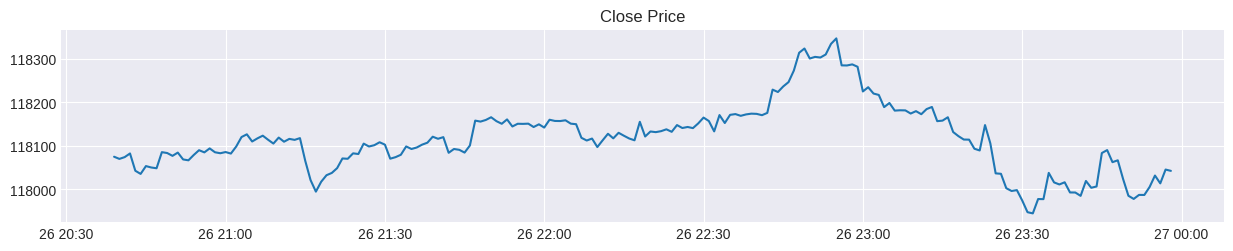

In [56]:
import matplotlib.pyplot as plt

last_500_features = features_1min.tail(200)
last_500_df = df_1min.tail(200)

indicators_to_plot = ['Close','Kal_300','Kal_600',]

# Separate Close from other indicators
close_to_plot = 'Close' if 'Close' in indicators_to_plot else None
other_indicators_to_plot = [col for col in indicators_to_plot if col != 'Close' and col in last_500_features.columns]

num_plots = len(other_indicators_to_plot) + (1 if close_to_plot else 0)

# Plotting
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 2.5 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Close price if requested
if close_to_plot:
    axes[current_plot_index].plot(last_500_df.index, last_500_df['Close'])
    axes[current_plot_index].set_title('Close Price')
    axes[current_plot_index].grid(True)
    current_plot_index += 1

# Plot each selected indicator (excluding 'Close')
for col in other_indicators_to_plot:
    axes[current_plot_index].plot(last_500_features.index, last_500_features[col])
    axes[current_plot_index].set_title(col)
    axes[current_plot_index].grid(True)
    current_plot_index += 1


#plt.tight_layout()
#plt.show()

## 5_min

In [ ]:
# Read the CSV file
df_5min = pd.read_csv(root_data + 'Data/'+symbol+'_M5.csv', index_col=0)
df_5min.index = pd.to_datetime(df_5min.index)
df_5min = df_5min.iloc[-1000000:,]

print('Min_Date : ', df_5min.index.min())
print('Min_Date : ', df_5min.index.max())
print('Number_Rows = ',len(df_5min.index))
print('\n')

df_5min.tail()

**Features**

In [ ]:
start_time = time.time()

features = create_features(df_5min)
features = features.dropna()

end_time = time.time()
execution_time = end_time - start_time

print("Number of features are:", features.shape[1])
print(features.shape)
features.to_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
print(f"Execution time: {execution_time:.2f} seconds")
features.tail(5)

In [ ]:
print("NaN counts per column (sorted):")
print(features.isnull().sum().sort_values(ascending=False), '\n')

In [ ]:
features = pd.read_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
features["Date"] = pd.to_datetime(features["Date"])
print(features.shape)
features.head(5)

**Scale_features**

In [ ]:
cols_to_scale = features.columns[1:]
cols_to_scale

In [ ]:
### Scale Features with Rolling Window
start_time = time.time()

window = 200
rolling = features[cols_to_scale].rolling(window)
features[cols_to_scale] = (features[cols_to_scale] - rolling.mean()) / rolling.std()

print("DataFrame with rolling-scaled features:")
print(features.shape)
features.head()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


In [ ]:
print("NaN counts per column (sorted):")
print(features.isnull().sum().sort_values(ascending=False), '\n')

In [ ]:
features.to_csv(root_data+'Results/'+symbol+'_M5_Scale_Features.csv')

## 10_min

In [ ]:
# Read the CSV file
df_10min = pd.read_csv(root_data + 'Data/'+symbol+'_M10.csv', index_col=0)
df_10min.index = pd.to_datetime(df_10min.index)
df_10min = df_10min.iloc[-100000:,]

print('Min_Date : ', df_10min.index.min())
print('Min_Date : ', df_10min.index.max())
print('Number_Rows = ',len(df_10min.index))
print('\n')

df_10min.tail()

Min_Date :  2023-08-28 07:20:00
Min_Date :  2025-07-27 00:00:00
Number_Rows =  100000




,Open,High,Low,Close,Volume,Spread
Date,,,,,,
2025-07-26 23:20:00,118118.63,118152.00,117967.75,117998.38,910,0
2025-07-26 23:30:00,118003.13,118045.75,117921.00,117993.00,1350,362
2025-07-26 23:40:00,117992.38,118100.13,117967.50,118023.88,1275,100
2025-07-26 23:50:00,118023.63,118052.38,117951.88,118042.63,1032,0
2025-07-27 00:00:00,117987.50,118067.13,117975.00,118051.63,433,1050


**Features**

In [ ]:
### Create the Features Set
features_10min = create_features(df_10min)
features_10min = features_10min.dropna()

# Add "10min_" prefix to all column names except 'Date'
features_10min = features_10min.add_prefix('10min_')
features_10min.rename(columns={'10min_Date': 'Date'}, inplace=True)

print("Number of features are:", features.shape[1])
print(features_10min.shape)
features_10min.to_csv(root_data+'Results/'+symbol+'_M10_Raw_Features.csv')
features_10min.tail(5)

Indicators (RSI/MFI/OBV):   0%|          | 0/3 [00:00<?, ?it/s]

RSI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

RSI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

OBV: diffs:   0%|          | 0/1 [00:00<?, ?it/s]

OBV: pairwise: 0it [00:00, ?it/s]

[Timing] Indicators block: 0.10s


Kalman & Derivatives:   0%|          | 0/3 [00:00<?, ?it/s]

Kalman pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Kalman block: 0.50s


Slopes (kal_len × slope_len):   0%|          | 0/9 [00:00<?, ?it/s]

slope_div: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

[Timing] Slopes block: 150.82s
Number of features are: 366
(99985, 365)


,10min_OBV,10min_RSI_3,10min_MFI_3,10min_RSI_7,10min_MFI_7,10min_RSI_14,10min_MFI_14,10min_RSI_3_diff,10min_RSI_7_diff,10min_RSI_14_diff,...,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-26 23:20:00,-845456.0,14.484819,-8.045692e-13,31.553670,64.054053,41.542614,58.926625,-12.113336,-10.901005,-6.925146,...,0,1,0,0,1,0,0,-1,-1,0
2025-07-26 23:30:00,-846806.0,14.040916,-7.119918e-13,31.122203,49.739390,41.248875,58.407434,-0.443903,-0.431467,-0.293739,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:40:00,-845531.0,31.986467,3.607232e+01,36.900079,51.023547,43.709161,59.523328,17.945551,5.777876,2.460287,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:50:00,-844499.0,42.852636,3.487067e+01,40.439391,34.923413,45.209480,52.838341,10.866169,3.539312,1.500319,...,0,0,0,0,0,0,0,0,0,0
2025-07-27 00:00:00,-844066.0,48.748168,6.233876e+01,42.253259,25.045209,45.954100,50.914197,5.895532,1.813867,0.744620,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("NaN counts per column (sorted):",'\n')
print(features_10min.isnull().sum().sort_values(ascending=False), '\n')

NaN counts per column (sorted): 

slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9    199
slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9    199
OBV                                                        199
RSI_3                                                      199
MFI_3                                                      199
                                                          ... 
MFI_3 - MFI_7                                              199
MFI_3 - MFI_14                                             199
MFI_7 - MFI_14                                             199
OBV_diff                                                   199
Date                                                         0
Length: 366, dtype: int64 



In [ ]:
features_10min = pd.read_csv(root_data+'Results/'+symbol+'_M10_Raw_Features.csv')
features_10min["Date"] = pd.to_datetime(features_10min["Date"])
print(features_10min.shape)
features_10min.head(5)

(99985, 366)


,Date,10min_OBV,10min_RSI_3,10min_MFI_3,10min_RSI_7,10min_MFI_7,10min_RSI_14,10min_MFI_14,10min_RSI_3_diff,10min_RSI_7_diff,...,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
0,2023-08-28 09:50:00,-5523.0,47.976951,2.844680e+01,33.650758,47.830364,28.341456,38.393043,32.737313,12.282079,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-28 10:00:00,-5078.0,56.683527,6.055715e+01,37.596126,43.066953,30.305107,45.280008,8.706576,3.945368,...,0,0,0,0,0,0,0,0,0,0
2,2023-08-28 10:10:00,-5680.0,28.946486,5.958309e+01,29.724932,25.122292,27.237055,40.890005,-27.737041,-7.871194,...,0,-1,0,0,-1,0,0,1,1,0
3,2023-08-28 10:20:00,-6253.0,15.850961,2.748439e+01,23.315010,23.534851,24.259950,39.279619,-13.095525,-6.409922,...,0,0,-1,0,0,-1,0,-1,0,1
4,2023-08-28 10:30:00,-6859.0,12.001749,-8.075944e-15,20.837409,23.477819,22.981437,35.194732,-3.849212,-2.477601,...,0,0,0,0,0,0,0,0,0,0


**Scale_features**

In [ ]:
cols_to_scale = features_10min.columns[1:]
cols_to_scale

Index(['10min_OBV', '10min_RSI_3', '10min_MFI_3', '10min_RSI_7', '10min_MFI_7',
       '10min_RSI_14', '10min_MFI_14', '10min_RSI_3_diff', '10min_RSI_7_diff',
       '10min_RSI_14_diff',
       ...
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9',
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3',
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6',
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9',
       '10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3',
       '10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6',
       '10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9',
       '10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6',
       '10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9',
       '10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9'],
      dtype='object', length=365)

In [ ]:
### Scale Features with Rolling Window
window = 200
rolling = features_10min[cols_to_scale].rolling(window)
features_10min[cols_to_scale] = (features_10min[cols_to_scale] - rolling.mean()) / rolling.std()

print("DataFrame with rolling-scaled features:")
print(features_10min.shape)
features_10min.tail()


DataFrame with rolling-scaled features:
(99985, 366)


,Date,10min_OBV,10min_RSI_3,10min_MFI_3,10min_RSI_7,10min_MFI_7,10min_RSI_14,10min_MFI_14,10min_RSI_3_diff,10min_RSI_7_diff,...,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
99980,2025-07-26 23:20:00,1.143835,-1.843418,-1.791219,-1.850145,0.422298,-1.777513,0.242242,-0.593213,-1.274148,...,-0.017109,2.835738,-0.07562,-0.040757,2.311907,-0.038032,-0.018215,-3.328181,-2.573518,0.031559
99981,2025-07-26 23:30:00,1.009541,-1.837793,-1.770482,-1.855928,-0.297521,-1.787742,0.204602,-0.006657,-0.029271,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559
99982,2025-07-26 23:40:00,1.117434,-1.020618,-0.589974,-1.411074,-0.223900,-1.477693,0.291035,0.908775,0.704940,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559
99983,2025-07-26 23:50:00,1.200365,-0.526559,-0.623546,-1.137135,-1.044233,-1.286629,-0.215838,0.548799,0.434904,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559
99984,2025-07-27 00:00:00,1.228747,-0.254282,0.274725,-0.993295,-1.540846,-1.186525,-0.356296,0.304585,0.234594,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559


In [ ]:
print("NaN counts per column (sorted):",'\n')
print(features_10min.isnull().sum().sort_values(ascending=False), '\n')

NaN counts per column (sorted): 

10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9    199
10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9    199
10min_OBV                                                        199
10min_RSI_3                                                      199
10min_MFI_3                                                      199
                                                                ... 
10min_MFI_3 - MFI_7                                              199
10min_MFI_3 - MFI_14                                             199
10min_MFI_7 - MFI_14                                             199
10min_OBV_diff                                                   199
Date                                                               0
Length: 366, dtype: int64 



In [ ]:
features_10min.to_csv(root_data+'Results/'+symbol+'_M10_Scale_Features.csv')

# Feature Importance

## Labels

In [57]:
lab = pd.read_csv(root_data + 'Results/'+symbol+'_'+strategy+'_'+time_frame+'_Strategy_Gen_Labels.csv', index_col=0)
lab['Date'] = pd.to_datetime(lab['Date'])

print('Min_Date    : ',lab['Date'].min())
print('Min_Date    : ',lab['Date'].max(),'\n')
print('Number_Rows : ',lab.shape,'\n')
print('Columns     : ',lab.columns)

lab['Open_Trade'].value_counts()

Min_Date    :  2023-01-01 00:05:00
Min_Date    :  2025-07-26 23:55:00 

Number_Rows :  (267395, 29) 

Columns     :  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'ATR',
       'kal_1', 'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade',
       'Entry_Date', 'Type', 'Trade_Number', 'st_Exit_Date', 'trade type',
       'st_Duration', 'st_row_PnL_close', 'st_row_PnL_high', 'st_row_PnL_Low',
       'st_row_PnL_low', 'st_Max', 'st_Min', 'st_PnL', 'st_atr_PnL',
       'st_atr_max_PnL'],
      dtype='object')


,count
Open_Trade,
1.0,19600
-1.0,19592


In [58]:
#analyse_column = 'st_atr_max_PnL'
analyse_column = 'st_Max'

st_max_0  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].sum()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].sum()


st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 0)),analyse_column].sum()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 0.7) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].sum()

st_max_5 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1) &
                   (lab['st_atr_max_PnL'] <= 1.5)),analyse_column].sum()

st_max_6 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1.5) &
                   (lab['st_atr_max_PnL'] <= 2)),analyse_column].sum()

st_max_7 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 2)),analyse_column].sum()


print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 & <= 1.5 = {st_max_5:,.2f}')
print(f'> 1.5 & <= 2 = {st_max_6:,.2f}')
print(f'> 2 = {st_max_7:,.2f}')

Total_Trades = 39,192

Mean st_atr_max_PnL = 190.11

Above_Mean = 5,300,556.56
Below_Mean = 2,149,989.95

<= 0.5 = 90.95
> 0.5 & <= 1 = 380,810.34
> 1 & <= 1.5 = 648,504.61
> 1.5 & <= 2 = 634,850.50
> 2 = 5,219,788.66


In [59]:
analyse_column = 'st_atr_max_PnL'

st_max_0 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].count()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].count()

st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                    (lab['st_atr_max_PnL'] <= 0.5)),analyse_column].count()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                     (lab['st_atr_max_PnL'] >= 0.5) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].count()

st_max_5 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] >= 1), analyse_column].count()

print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 = {st_max_5:,.2f}')


Total_Trades = 39,192

Mean st_atr_max_PnL = 1.93

Above_Mean = 12,033.00
Below_Mean = 27,157.00

<= 0.5 = 11,681.00
> 0.5 & <= 1 = 7,741.00
> 1 = 19,768.00


In [60]:
# --- Parámetros / campos
result_field = 'st_atr_max_PnL'

valid = (
    (lab['Type'] == direction) &
    (lab['Open_Trade'].isin([1, -1])) &
    (lab[result_field].notna()))


# --- Etiquetado en la columna "label" con valores 4/5/6
lab['label'] = np.nan
lab.loc[valid & (lab[result_field] <= 1), 'label'] = 0
lab.loc[valid & (lab[result_field] >= 1), 'label'] = 1


# --- Mantener solo filas válidas y con label
lab = lab.loc[valid & lab['label'].notna()].copy()
lab['label'] = lab['label'].astype('int8')

# --- Ver distribución de labels 4/5/6
print('\nValue counts de label 4/5/6:')
print(lab['label'].value_counts(dropna=False).sort_index())



Value counts de label 4/5/6:
label
0     9537
1    10054
Name: count, dtype: int64


## Features

In [101]:
raw_feat_1min = pd.read_csv(root_data+'Results/'+symbol+'_M1_Raw_Features.csv')
raw_feat_1min["Date"] = pd.to_datetime(raw_feat_1min["Date"])
print(raw_feat_1min.shape)
#raw_feat_1min.head(5)

(499477, 430)


In [102]:
scale_feat_1min = pd.read_csv(root_data+'Results/'+symbol+'_M1_Scale_Features.csv')
scale_feat_1min = scale_feat_1min.drop('Unnamed: 0', axis=1)
scale_feat_1min.rename(columns={'1min_Date': 'Date'}, inplace=True)
scale_feat_1min["Date"] = pd.to_datetime(scale_feat_1min["Date"])
print(scale_feat_1min.shape)
scale_feat_1min.tail(5)


(499477, 430)


,Date,1min_RSI_3,1min_MFI_3,1min_ADX_3,1min_OBV_3,1min_AD_3,1min_ROCP_3,1min_RSI_5,1min_MFI_5,1min_ADX_5,...,1min_slope_angle_1000_18,1min_slope_angle_signal_1000_18,1min_slope_lin_reg_1000_18,1min_slope_lin_reg_signal_1000_18,1min_slope_div_1000_21,1min_slope_signal_1000_21,1min_slope_angle_1000_21,1min_slope_angle_signal_1000_21,1min_slope_lin_reg_1000_21,1min_slope_lin_reg_signal_1000_21
499472,2025-07-26 23:54:00,0.356180,0.707436,-0.649800,-1.207690,0.801441,0.832038,-0.077736,-0.277946,-0.906375,...,-0.656513,-1.080761,-0.920745,-1.148457,0.614267,-1.091702,1.039973,-1.091702,-0.787023,-1.172198
499473,2025-07-26 23:55:00,1.111766,1.375311,-0.736097,-0.949922,0.905369,1.315531,0.628313,0.483450,-1.039078,...,-0.904168,-1.069946,-1.046838,-1.148457,0.658065,0.911421,1.030803,0.911421,-0.915814,-1.172198
499474,2025-07-26 23:56:00,0.096539,0.757372,-0.789043,-1.078254,0.814672,0.801986,0.029358,0.710128,-1.140946,...,-0.941861,-1.059255,-1.131922,-1.148457,0.470794,-1.080761,1.014369,-1.080761,-1.026175,-1.172198
499475,2025-07-26 23:57:00,0.967146,0.795440,-0.355174,-0.805486,0.969336,1.190543,0.760562,1.266694,-1.002336,...,0.891578,0.939339,-1.185582,-1.148457,0.400998,-1.069946,1.000207,-1.069946,-1.103179,-1.172198
499476,2025-07-26 23:58:00,0.781286,0.856191,-0.067156,-1.143126,0.819077,0.345607,0.648457,1.276027,-0.891546,...,1.003578,0.939339,-1.204082,-1.148457,0.388519,-1.059255,0.996913,-1.059255,-1.134948,-1.172198


In [103]:
scale_feat_1min.tail(5)

,Date,1min_RSI_3,1min_MFI_3,1min_ADX_3,1min_OBV_3,1min_AD_3,1min_ROCP_3,1min_RSI_5,1min_MFI_5,1min_ADX_5,...,1min_slope_angle_1000_18,1min_slope_angle_signal_1000_18,1min_slope_lin_reg_1000_18,1min_slope_lin_reg_signal_1000_18,1min_slope_div_1000_21,1min_slope_signal_1000_21,1min_slope_angle_1000_21,1min_slope_angle_signal_1000_21,1min_slope_lin_reg_1000_21,1min_slope_lin_reg_signal_1000_21
499472,2025-07-26 23:54:00,0.356180,0.707436,-0.649800,-1.207690,0.801441,0.832038,-0.077736,-0.277946,-0.906375,...,-0.656513,-1.080761,-0.920745,-1.148457,0.614267,-1.091702,1.039973,-1.091702,-0.787023,-1.172198
499473,2025-07-26 23:55:00,1.111766,1.375311,-0.736097,-0.949922,0.905369,1.315531,0.628313,0.483450,-1.039078,...,-0.904168,-1.069946,-1.046838,-1.148457,0.658065,0.911421,1.030803,0.911421,-0.915814,-1.172198
499474,2025-07-26 23:56:00,0.096539,0.757372,-0.789043,-1.078254,0.814672,0.801986,0.029358,0.710128,-1.140946,...,-0.941861,-1.059255,-1.131922,-1.148457,0.470794,-1.080761,1.014369,-1.080761,-1.026175,-1.172198
499475,2025-07-26 23:57:00,0.967146,0.795440,-0.355174,-0.805486,0.969336,1.190543,0.760562,1.266694,-1.002336,...,0.891578,0.939339,-1.185582,-1.148457,0.400998,-1.069946,1.000207,-1.069946,-1.103179,-1.172198
499476,2025-07-26 23:58:00,0.781286,0.856191,-0.067156,-1.143126,0.819077,0.345607,0.648457,1.276027,-0.891546,...,1.003578,0.939339,-1.204082,-1.148457,0.388519,-1.059255,0.996913,-1.059255,-1.134948,-1.172198


In [104]:
raw_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
raw_feat_5min["Date"] = pd.to_datetime(raw_feat_5min["Date"])
print(raw_feat_5min.shape)
#raw_feat_5min.head(5)

(267380, 366)


In [105]:
scale_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Scale_Features.csv')
scale_feat_5min = scale_feat_5min.drop('Unnamed: 0', axis=1)
scale_feat_5min["Date"] = pd.to_datetime(scale_feat_5min["Date"])
print(scale_feat_5min.shape)
#scale_feat_5min.head(5)

(267380, 366)


In [106]:
print("NaN counts per column (sorted):",'\n')
print(scale_feat_5min.isnull().sum().sort_values(ascending=False), '\n')

NaN counts per column (sorted): 

slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9    199
slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9    199
OBV                                                        199
RSI_3                                                      199
MFI_3                                                      199
                                                          ... 
MFI_3 - MFI_7                                              199
MFI_3 - MFI_14                                             199
MFI_7 - MFI_14                                             199
OBV_diff                                                   199
Date                                                         0
Length: 366, dtype: int64 



In [107]:
raw_feat_10min = pd.read_csv(root_data+'Results/'+symbol+'_M10_Raw_Features.csv')
raw_feat_10min["Date"] = pd.to_datetime(raw_feat_10min["Date"])

# Add "10min_" prefix to all column names except 'Date'
cols_to_prefix = [col for col in raw_feat_10min.columns if col != 'Date']
raw_feat_10min.rename(columns={col: col for col in cols_to_prefix}, inplace=True)

print(raw_feat_10min.shape)
#raw_feat_10min.head(5)

(99985, 366)


In [108]:
scale_feat_10min = pd.read_csv(root_data+'Results/'+symbol+'_M10_Scale_Features.csv')
scale_feat_10min = scale_feat_10min.drop('Unnamed: 0', axis=1)
scale_feat_10min["Date"] = pd.to_datetime(scale_feat_10min["Date"])

# Add "10min_" prefix to all column names except 'Date'
cols_to_prefix = [col for col in scale_feat_10min.columns if col != 'Date']
scale_feat_10min.rename(columns={col:col for col in cols_to_prefix}, inplace=True)

print(scale_feat_10min.shape)
#scale_feat_10min.head(5)

(56511, 366)


In [109]:
print("NaN counts per column (sorted):",'\n')
print(scale_feat_10min.isnull().sum().sort_values(ascending=False), '\n')

NaN counts per column (sorted): 

10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9    199
10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9    199
10min_OBV                                                        199
10min_RSI_3                                                      199
10min_MFI_3                                                      199
                                                                ... 
10min_MFI_3 - MFI_7                                              199
10min_MFI_3 - MFI_14                                             199
10min_MFI_7 - MFI_14                                             199
10min_OBV_diff                                                   199
Date                                                               0
Length: 366, dtype: int64 



## Merge

In [110]:
data_type = 'Scale'

In [111]:
# First merge scale_feat_5min with scale_feat_10min and apply forward fill
merged_features = scale_feat_5min.merge(scale_feat_10min, on='Date', how='left').ffill()

# Now merge with scale_feat_1min
merged_features = merged_features.merge(scale_feat_1min, on='Date', how='left').ffill()

df = pd.merge(lab[['Date', 'label', 'Open_Trade']], merged_features, on='Date', how='left')

cols = df.columns.tolist()
cols.remove('label')
cols.insert(1, 'label')
df = df[cols]

In [112]:
# Check for columns with '1min_' prefix
one_min_cols = [col for col in df.columns if '1min_' in col]

if one_min_cols:
    print("Columns with '1min_' prefix found:")
    print(one_min_cols)
else:
    print("No columns with '1min_' prefix found.")

Columns with '1min_' prefix found:
['1min_RSI_3', '1min_MFI_3', '1min_ADX_3', '1min_OBV_3', '1min_AD_3', '1min_ROCP_3', '1min_RSI_5', '1min_MFI_5', '1min_ADX_5', '1min_OBV_5', '1min_AD_5', '1min_ROCP_5', '1min_RSI_7', '1min_MFI_7', '1min_ADX_7', '1min_OBV_7', '1min_AD_7', '1min_ROCP_7', '1min_RSI_10', '1min_MFI_10', '1min_ADX_10', '1min_OBV_10', '1min_AD_10', '1min_ROCP_10', '1min_RSI_15', '1min_MFI_15', '1min_ADX_15', '1min_OBV_15', '1min_AD_15', '1min_ROCP_15', '1min_RSI_17', '1min_MFI_17', '1min_ADX_17', '1min_OBV_17', '1min_AD_17', '1min_ROCP_17', '1min_RSI_20', '1min_MFI_20', '1min_ADX_20', '1min_OBV_20', '1min_AD_20', '1min_ROCP_20', '1min_RSI_22', '1min_MFI_22', '1min_ADX_22', '1min_OBV_22', '1min_AD_22', '1min_ROCP_22', '1min_RSI_66', '1min_MFI_66', '1min_ADX_66', '1min_OBV_66', '1min_AD_66', '1min_ROCP_66', '1min_RSI_126', '1min_MFI_126', '1min_ADX_126', '1min_OBV_126', '1min_AD_126', '1min_ROCP_126', '1min_RSI_252', '1min_MFI_252', '1min_ADX_252', '1min_OBV_252', '1min_AD_252

In [117]:
print(df.shape,'\n')
print('Label_Counts : ',df.label.value_counts(),'\n')
print(list(df.columns), '\n')

# Add NaN count per column, sorted
print("NaN counts per column (sorted):")
print(df.isnull().sum().sort_values(ascending=False), '\n')

#df.head(5)

(19591, 568) 

Label_Counts :  label
1    10054
0     9537
Name: count, dtype: int64 

['Date', 'label', 'RSI_3_diff', 'RSI_7_diff', 'RSI_14_diff', 'RSI_3 - RSI_7', 'RSI_3 - RSI_14', 'RSI_7 - RSI_14', 'MFI_3_diff', 'MFI_7_diff', 'MFI_14_diff', 'MFI_3 - MFI_7', 'MFI_3 - MFI_14', 'MFI_7 - MFI_14', 'OBV_diff', 'slope_div_300_3_diff', 'slope_signal_300_3_diff', 'slope_angle_300_3_diff', 'slope_angle_signal_300_3_diff', 'slope_lin_reg_300_3_diff', 'slope_lin_reg_signal_300_3_diff', 'slope_div_300_6_diff', 'slope_signal_300_6_diff', 'slope_angle_300_6_diff', 'slope_angle_signal_300_6_diff', 'slope_lin_reg_300_6_diff', 'slope_lin_reg_signal_300_6_diff', 'slope_div_300_9_diff', 'slope_signal_300_9_diff', 'slope_angle_300_9_diff', 'slope_angle_signal_300_9_diff', 'slope_lin_reg_300_9_diff', 'slope_lin_reg_signal_300_9_diff', 'slope_div_600_3_diff', 'slope_signal_600_3_diff', 'slope_angle_600_3_diff', 'slope_angle_signal_600_3_diff', 'slope_lin_reg_600_3_diff', 'slope_lin_reg_signal_600_3_diff',

In [118]:
# Select features containing 'diff' or '-' in their names
diff_features = df.filter(regex='diff|-')

# Create a new dataframe with the Date column, label and the selected features
df_diff = pd.concat([df[['Date', 'label']], diff_features], axis=1)

print("DataFrame with difference features:")
print(df_diff.shape,'\n')
print('Label_Counts : ',df_diff.label.value_counts(),'\n')
print(list(df_diff.columns), '\n')

# Add NaN count per column, sorted
print("NaN counts per column (sorted):")
print(df_diff.isnull().sum().sort_values(ascending=False), '\n')

#df_diff.head(5)

DataFrame with difference features:
(19591, 568) 

Label_Counts :  label
1    10054
0     9537
Name: count, dtype: int64 

['Date', 'label', 'RSI_3_diff', 'RSI_7_diff', 'RSI_14_diff', 'RSI_3 - RSI_7', 'RSI_3 - RSI_14', 'RSI_7 - RSI_14', 'MFI_3_diff', 'MFI_7_diff', 'MFI_14_diff', 'MFI_3 - MFI_7', 'MFI_3 - MFI_14', 'MFI_7 - MFI_14', 'OBV_diff', 'slope_div_300_3_diff', 'slope_signal_300_3_diff', 'slope_angle_300_3_diff', 'slope_angle_signal_300_3_diff', 'slope_lin_reg_300_3_diff', 'slope_lin_reg_signal_300_3_diff', 'slope_div_300_6_diff', 'slope_signal_300_6_diff', 'slope_angle_300_6_diff', 'slope_angle_signal_300_6_diff', 'slope_lin_reg_300_6_diff', 'slope_lin_reg_signal_300_6_diff', 'slope_div_300_9_diff', 'slope_signal_300_9_diff', 'slope_angle_300_9_diff', 'slope_angle_signal_300_9_diff', 'slope_lin_reg_300_9_diff', 'slope_lin_reg_signal_300_9_diff', 'slope_div_600_3_diff', 'slope_signal_600_3_diff', 'slope_angle_600_3_diff', 'slope_angle_signal_600_3_diff', 'slope_lin_reg_600_3_diff'

In [115]:
#### Cell to work ON








In [119]:
df = df_diff.copy()

## ML

In [120]:
# ===================== 1. ENTRENAR Y OBTENER IMPORTANCIAS =====================
def compute_xgb_importance(
    X: pd.DataFrame,
    y: pd.Series,
    task: str = "classification",
    random_state: int = 42,
    **xgb_params: Any
) -> Tuple[pd.DataFrame, Any]:
    """
    Entrena un modelo XGBoost y devuelve:
      - imp_df: DataFrame con 'feature', 'importance' y 'cum_importance'.
      - model : modelo ya entrenado.

    Soporta:
      • Clasificación binaria o multiclase (detecta nº de clases).
      • Regresión (si task != 'classification').

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características (sin la columna objetivo).
    y : pd.Series
        Etiquetas objetivo. Puede ser binaria (0/1) o multiclase (0..K-1).
    task : str, opcional
        "classification" (default) o "regression".
    random_state : int, opcional
        Semilla para reproducibilidad.
    **xgb_params : dict
        Parámetros adicionales para el estimador de XGBoost.

    Returns
    -------
    (imp_df, model)
        imp_df : DataFrame con importancias y su acumulado.
        model  : instancia entrenada de XGBClassifier / XGBRegressor.
    """
    default_params: Dict[str, Any] = dict(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )
    default_params.update(xgb_params)

    if task == "classification":
        # Detectar nº de clases
        classes = np.unique(y)
        n_classes = len(classes)

        # XGBClassifier ajusta objetivo automáticamente, pero lo explicitamos:
        if n_classes > 2:
            default_params.setdefault("objective", "multi:softprob")
            default_params.setdefault("num_class", n_classes)
            eval_metric = "mlogloss"
        else:
            default_params.setdefault("objective", "binary:logistic")
            eval_metric = "logloss"

        model = XGBClassifier(eval_metric=eval_metric, **default_params)

    else:
        model = XGBRegressor(**default_params)

    model.fit(X, y)

    imp_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    total_imp = imp_df["importance"].sum()
    if total_imp == 0:
        # Evitar división por cero si el modelo devuelve todo cero (raro, pero posible)
        imp_df["cum_importance"] = 0.0
    else:
        imp_df["cum_importance"] = imp_df["importance"].cumsum() / total_imp

    return imp_df, model

In [121]:
# ===================== 2. SELECCIÓN DE FEATURES =====================
def select_features_with_importance(
    X: pd.DataFrame,
    imp_df: pd.DataFrame,
    top_n: Optional[int] = None,
    threshold: Optional[str | float] = None,
    cum_threshold: Optional[float] = 0.8
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Selección flexible de variables a partir de importancias de XGBoost.

    Reglas:
      - Si top_n no es None           => usa el top_n.
      - Else si cum_threshold no None => usa importancia acumulada (p.ej. 0.8 = 80%).
      - Else usa threshold ('median', 'mean' o valor numérico).

    Devuelve (X_reducido, lista_de_features).

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características original.
    imp_df : pd.DataFrame
        DataFrame devuelto por compute_xgb_importance.
    top_n : int | None
        Número fijo de variables a conservar.
    threshold : str | float | None
        Umbral de importancia. Si str, usar 'median' o 'mean'.
    cum_threshold : float | None
        Porcentaje acumulado de importancia (0-1). Si None, se ignora.

    Returns
    -------
    (X_sel, keep)
        X_sel : subset de X con columnas seleccionadas.
        keep  : lista de nombres de columnas seleccionadas.
    """
    if top_n is not None:
        keep = imp_df.head(top_n)["feature"].tolist()

    elif cum_threshold is not None:
        keep_mask = imp_df["cum_importance"] <= float(cum_threshold)
        keep = imp_df.loc[keep_mask, "feature"].tolist()
        # asegurar que haya al menos una más para no quedarnos exactamente en el corte
        if len(keep) < len(imp_df):
            keep.append(imp_df.iloc[len(keep)]["feature"])

    else:
        if threshold is None:
            threshold = "median"
        if isinstance(threshold, str):
            thr_val = imp_df["importance"].agg(threshold)
        else:
            thr_val = float(threshold)
        keep = imp_df.loc[imp_df["importance"] >= thr_val, "feature"].tolist()

    return X[keep], keep

In [122]:
# ===================== 3. BÚSQUEDA DEL MEJOR UMBRAL ACUMULADO =====================
def find_best_cum_threshold(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    task: str = "classification",
    thresholds: Tuple[float, ...] = (0.6, 0.7, 0.8, 0.9),
    random_state: int = 42,
    metric: str = "auto",
    **xgb_params: Any
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Entrena un XGB en train, calcula importancias y prueba varios umbrales
    acumulados para ver cuál da la mejor métrica en valid.

    Para CLASIFICACIÓN:
        - Detecta nº de clases.
        - Métrica por defecto (metric="auto"):
            • Binaria: ROC-AUC (probabilidades de la clase positiva).
            • Multiclase: ROC-AUC macro OVR (usa predict_proba).
          Alternativas: metric="f1_macro", "accuracy", "logloss" (se MINIMIZA).
    Para REGRESIÓN:
        - Usa R^2.

    Devuelve:
        best_thr, res_df_ordenado_por_score_desc, imp_df

    Parámetros
    ----------
    X_train, y_train, X_valid, y_valid : pd.DataFrame / pd.Series
        Particiones de entrenamiento y validación.
    task : str
        "classification" (default) o "regression".
    thresholds : tuple[float, ...]
        Valores de umbral de importancia acumulada a evaluar (0-1).
    random_state : int
        Semilla para reproducibilidad.
    metric : str
        "auto" (default), "roc_auc", "f1_macro", "accuracy", "logloss" (clasif) o "r2" (regresión).
    **xgb_params : dict
        Parámetros extra para el estimador de XGBoost (pasan a compute y a los modelos internos).

    Returns
    -------
    (best_thr, res_df, imp_df)
        best_thr : float
            Umbral con mejor score (o menor logloss si metric='logloss').
        res_df : pd.DataFrame
            Tabla con resultados por umbral (n_features, score).
        imp_df : pd.DataFrame
            Importancias calculadas en X_train / y_train.
    """
    imp_df, _ = compute_xgb_importance(
        X_train, y_train, task=task, random_state=random_state, **xgb_params
    )

    results = []

    # Detectar nº de clases si es clasificación
    if task == "classification":
        classes = np.unique(y_train)
        n_classes = len(classes)
        if metric == "auto":
            metric_to_use = "roc_auc" if n_classes == 2 else "roc_auc"
        else:
            metric_to_use = metric
    else:
        metric_to_use = "r2" if metric == "auto" else metric

    for thr in thresholds:
        X_tr_sel, cols = select_features_with_importance(
            X_train, imp_df, cum_threshold=thr, top_n=None, threshold=None
        )
        X_va_sel = X_valid[cols]

        if task == "classification":
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)

            if n_classes > 2:
                params.setdefault("objective", "multi:softprob")
                params.setdefault("num_class", n_classes)
                eval_metric = "mlogloss"
            else:
                params.setdefault("objective", "binary:logistic")
                eval_metric = "logloss"

            model_sel = XGBClassifier(eval_metric=eval_metric, **params)
            model_sel.fit(X_tr_sel, y_train)

            # Probabilidades y predicciones
            proba = model_sel.predict_proba(X_va_sel)
            pred  = np.argmax(proba, axis=1) if n_classes > 2 else (proba[:, 1] >= 0.5).astype(int)

            # Calcular métrica
            if metric_to_use == "roc_auc":
                if n_classes == 2:
                    score = roc_auc_score(y_valid, proba[:, 1])
                else:
                    # AUC macro One-vs-Rest
                    score = roc_auc_score(y_valid, proba, multi_class="ovr", average="macro")
            elif metric_to_use == "f1_macro":
                score = f1_score(y_valid, pred, average="macro")
            elif metric_to_use == "accuracy":
                score = accuracy_score(y_valid, pred)
            elif metric_to_use == "logloss":
                # En este caso, menor es mejor. Guardamos negativo para mantener criterio "mayor mejor".
                score = -log_loss(y_valid, proba, labels=np.unique(y_train))
            else:
                raise ValueError(f"Métrica no soportada: {metric_to_use}")

        else:
            # REGRESIÓN
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)
            model_sel = XGBRegressor(**params)
            model_sel.fit(X_tr_sel, y_train)
            pred = model_sel.predict(X_va_sel)

            if metric_to_use == "r2":
                score = r2_score(y_valid, pred)
            else:
                raise ValueError(f"Métrica de regresión no soportada: {metric_to_use}")

        results.append({"cum_threshold": thr, "n_features": len(cols), "score": score})

    # Ordenar (si usamos logloss negado, mayor sigue siendo mejor)
    res_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)
    best_thr = float(res_df.iloc[0]["cum_threshold"])
    return best_thr, res_df, imp_df

In [123]:
def remove_highly_correlated_features(df, threshold=0.9):

    # Solo numéricos para evitar errores y acelerar
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))

    to_drop = []
    for col in tqdm(upper.columns, desc=f"Pruning corr > {threshold}", unit="col", leave=False):
        if (upper[col] > threshold).any():
            to_drop.append(col)

    return df.drop(columns=to_drop, errors="ignore"), to_drop


In [124]:
# ===================== 3. PIPELINE PRINCIPAL =====================
df = df.dropna()
y = df['label']
X = df.iloc[:, 2:]

# --- 3.3 Split temporal (ejemplo simple 80/20) ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 3.4 Remove correlated features ---
X_train_filtered, dropped_features = remove_highly_correlated_features(X_train, threshold=0.9)
X_test_filtered = X_test.drop(columns=dropped_features)

# Baseline logistic regression with time-series CV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_filtered)
tscv = TimeSeriesSplit(n_splits=5)
baseline = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y_train, cv=tscv).mean()
print('Logistic regression CV accuracy:', baseline)

# --- 3.5 Importancias con XGBoost ---
imp_df, xgb_model = compute_xgb_importance(X_train_filtered, y_train, task='classification')

print('=== Importancias XGBoost ===')
print(imp_df.head(20))
print(f'Total features: {len(imp_df)}')

# --- 3.6 Selección (elige una opción) ---
X_train_sel, keep_cols = select_features_with_importance(X_train_filtered, imp_df, cum_threshold=0.8)
X_test_sel = X_test_filtered[keep_cols]

print(f'Features seleccionadas: {len(keep_cols)}')
importance_map = imp_df.set_index("feature")["importance"]
selected_importances = pd.DataFrame({
    "feature": keep_cols,
    "importance": importance_map.reindex(keep_cols).values
})
selected_importances.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_ImportantCols.csv', index=False)

# Save dataset with selected features
df_selected = df[['Date', 'label'] + keep_cols]
df_selected.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_Features.csv', index=False)

# Time-series cross-validation with XGBoost
xgb_cv = XGBClassifier(eval_metric='logloss', n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
xgb_scores = cross_val_score(xgb_cv, X_train_sel, y_train, cv=tscv, scoring='accuracy')
print('XGBoost CV accuracy:', xgb_scores.mean())


Pruning corr > 0.9:   0%|          | 0/566 [00:00<?, ?col/s]

Logistic regression CV accuracy: 0.5475324675324675
=== Importancias XGBoost ===
                                              feature  importance  \
0                                    10min_RSI_3_diff    0.012965   
1                                 10min_RSI_3 - RSI_7    0.009111   
2                       10min_slope_signal_600_3_diff    0.006754   
3                        10min_slope_angle_900_3_diff    0.006637   
4                          10min_slope_div_300_3_diff    0.005540   
5                      10min_slope_lin_reg_300_3_diff    0.005012   
6                       10min_slope_signal_900_9_diff    0.004928   
7                          10min_slope_div_300_6_diff    0.004785   
8                        10min_slope_angle_600_3_diff    0.004449   
9       10min_slope_signal_300_3 - slope_signal_900_9    0.004434   
10                               slope_div_300_6_diff    0.004409   
11                      10min_slope_signal_900_3_diff    0.004374   
12  10min_slope_lin_re

# Encode_Features

In [ ]:
### Encode Features

cols_to_scale = df.columns[1:]
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(cols_to_scale),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(cols_to_scale), activation='linear'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder using the scaled features
cols_to_scale = df.columns[1:]
autoencoder = model.fit(df[cols_to_scale], df[cols_to_scale], epochs=100, batch_size=32)

In [ ]:
# Plot the graph of Loss versus Epoch
plt.plot(autoencoder.history["loss"])
plt.plot(figsize=(15, 7))
plt.title('Loss vs. Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

In [ ]:
# Select the columns to be scaled (from index 6 onwards)
cols_to_scale = df.columns[1:]

reconstruction_error = np.square(df[cols_to_scale] - model.predict(df[cols_to_scale]))
feature_reconstruction_error = np.mean(reconstruction_error, axis=0)
feature_reconstruction_error_df = pd.DataFrame(feature_reconstruction_error, index=cols_to_scale).T

overall_reconstruction_error = feature_reconstruction_error_df.mean().mean()
print('\n','\n', f"\033[1mOverall Reconstruction Error: {overall_reconstruction_error:.4f}\033[0m", '\n','\n')

# Print the individual features error in a horizontal format
display(feature_reconstruction_error_df)

You can see that certain features have very low error, but some might have an error as high as 0.2. However, overall the error rate is 0.04 and thus, we can move forward.

Let us now move towards finding the reduced features. This is done in the following steps.

**Extract the encoder part of the autoencoder**:
You will extract the encoder part of the autoencoder, which compresses the data into a reduced-dimensional representation. This part includes the first three layers of the model.

Use the encoder to obtain the reduced-dimensional representation:
We use the encoder to transform the input test data `(X_test)` into a reduced-dimensional representation `(X_encoded_test)`. This represents an encoded version of the input data.

In [ ]:
# Re-create the encoder from the layers of the successfully trained model
encoder = Sequential(model.layers[:3])
X_encoded_test = encoder.predict(X[cols_to_scale]) # Use the scaled features for prediction

In [ ]:

# ── NUEVO: añade la columna Date al DataFrame codificado ──
dates = df['Date'].reset_index(drop=True)                 # 1) copia la fecha
features_enc = pd.DataFrame(                              # 2) crea el DF codificado
    X_encoded_test,
    columns=[f'Encoded_{i}' for i in range(X_encoded_test.shape[1])]
)
features_enc.insert(0, 'Date', dates)
features_enc.head(5)

In [ ]:
features_enc.shape

In [ ]:
### Save the encoder model

encoder_save_path = root_data+'Models/'+symbol+'_'+direction+'_'+data_type+'_ahm_encoder_model.keras'
os.makedirs(os.path.dirname(encoder_save_path), exist_ok=True)
encoder.save(encoder_save_path)
print(f"Encoder model saved successfully at: {encoder_save_path}")

In [ ]:
features_enc.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_Enc_Features.csv')

# Varios